
**Install requirements**

In [1]:
!pip3 install 'torch==1.3.1'
!pip3 install 'torchvision==0.5.0'
!pip3 install 'Pillow-SIMD'
!pip3 install 'tqdm'
!pip install -U pillow

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
ERROR: Could not find a version that satisfies the requirement torch==1.3.1 (from versions: 1.4.0, 1.5.0, 1.5.1, 1.6.0, 1.7.0, 1.7.1, 1.8.0, 1.8.1, 1.9.0, 1.9.1, 1.10.0, 1.10.1, 1.10.2, 1.11.0, 1.12.0, 1.12.1, 1.13.0, 1.13.1)
ERROR: No matching distribution found for torch==1.3.1
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.0 MB 15.6 MB/s 
     |████████████████████████████████| 753.4 MB 21 kB/s 
  Attempting uninstall: torch
    Found existing installation: torch 1.13.0+cu116
    Uninstalling torch-1.13.0+cu116:
      Successfully uninstalled torch-1.13.0+cu116
  Attempting uninstall: torchvision
    Found existing installation: torchvision 0.14.0+cu116
    Uninstalling torchvision-0.14.0+cu116:
      Successfully uninstalled torchvision-0.14.0+cu116
ERROR: pip's dependency resolver does not c

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 3.2 MB 30.8 MB/s 
  Attempting uninstall: pillow
    Found existing installation: Pillow 7.1.2
    Uninstalling Pillow-7.1.2:
      Successfully uninstalled Pillow-7.1.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
fastai 2.7.10 requires torch<1.14,>=1.7, but you have torch 1.4.0 which is incompatible.
fastai 2.7.10 requires torchvision>=0.8.2, but you have torchvision 0.5.0 which is incompatible.


**Import libraries**

In [1]:
import os
import logging

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.init as init
import torch.nn.functional
from torch.utils.data import Subset, DataLoader
from torch.backends import cudnn

import torchvision
from torchvision import transforms
from torchvision.models import alexnet

import matplotlib.pyplot as plt
import numpy as np

from PIL import Image
from tqdm import tqdm
import copy
import time

**Set Arguments**

Here we set the constants.
It is indicated to use a learning rate equal to 0.1, but then it is specified to use a LR scheduler

In [23]:
DEVICE = 'cuda' # 'cuda' or 'cpu'

NUM_CLASSES = 100

BATCH_SIZE = 128     # Higher batch sizes allows for larger learning rates. An empirical heuristic suggests that, when changing
                     # the batch size, learning rate should change by the same factor to have comparable results

LR = 0.1            # The initial Learning Rate

# **********************
# LR SCHEDULER -> None or cosine annealing (https://pytorch.org/docs/stable/generated/torch.optim.lr_scheduler.CosineAnnealingLR.html).
# What is cosine annealing?
# torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max, eta_min=0, last_epoch=- 1, verbose=False)
# Parameters:
# - optimizer (Optimizer) – Wrapped optimizer.
# - T_max (int) – Maximum number of iterations.
# - eta_min (float) – Minimum learning rate. Default: 0.
# - last_epoch (int) – The index of last epoch. Default: -1.
# - verbose (bool) – If True, prints a message to stdout for each update. Default: False.

COSINE_ANNEALING = True
GN_LAYERS = True

# **********************

MOMENTUM = 0.9       # Hyperparameter for SGD, keep this at 0.9 when using SGD
WEIGHT_DECAY = 0.0001  # Regularization, you can keep this at the default

NUM_EPOCHS = 160      # Total number of training epochs (iterations over dataset)
STEP_SIZE = 20       # How many epochs before decreasing learning rate (if using a step-down policy)
GAMMA = 1          # Multiplicative factor for learning rate step-down

LOG_FREQUENCY = 25   #frequenza con cui viene stampato qualcosa

#TRAIN_SIZE = 0.5     # split between training and validation sets
PRETRAINED = True       # If 'True' the NETWORK will be pre-trained on ImageNet dataset
FREEZE = 'no_freezing'   # Available choice: 'no_freezing', 'conv_layers', 'fc_layers'
RANDOM = 42

# Data augmentation
AUG_PROB = 0.5   # the probability with witch each image is transformed at training time during each epoch

**Define Data Preprocessing**

Use the standard data augmentation pipeline: random crop, random horizontal flip,
per-pixel normalization.

In [24]:
if PRETRAINED : 
  mean, std = (0.5071, 0.4867, 0.4408), (0.2675, 0.2565, 0.2761)
else :
  mean, std = (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)                       

aug_transformation = transforms.Compose([
    transforms.RandomCrop(32, padding = 4),
    transforms.RandomHorizontalFlip(p = 1)
])

aug_pipeline = transforms.Compose([
    transforms.RandomApply([aug_transformation], p = AUG_PROB),
    transforms.ToTensor(),
    transforms.Normalize(mean,std)
])

transform_train = aug_pipeline
transform_test = transforms.Compose([transforms.ToTensor(), transforms.Normalize(mean,std)])

**Prepare Dataset (CIFAR 100)**

In [25]:
from torch.utils.data import DataLoader, Subset
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit #funzione simile a sklearn.model_selection.train_test_split per shufflorare gli indici
from torch.utils.data import random_split

train_dataset = torchvision.datasets.CIFAR100(root='./data', train=True, download=True, transform=transform_train)
test_dataset = torchvision.datasets.CIFAR100(root='./data', train=False, download=True, transform=transform_test)

val_size = 5000
train_size = len(train_dataset) - val_size
train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])


"""
# generate indices: instead of the actual data we pass in integers instead
train_indexes, val_indexes = train_test_split(list(range(len(train_dataset))), test_size=0.1)


print(f"Train Indexes = \t{min(train_indexes)}")
print(f"Val Indexes = \t{min(val_indexes)}")

# split the train_dataset in train and val  
sss = StratifiedShuffleSplit(n_splits=1, train_size=0.5, random_state=RANDOM)

X = [img[0] for img in train_dataset.samples]
y = [lab[1] for lab in train_dataset.samples]

for train_idx, val_idx in sss.split(X,y) :
  train_indexes = train_idx
  val_indexes = val_idx


# Generate subset based on indexes
train_dataset = Subset(train_dataset, train_indexes)
val_dataset = Subset(train_dataset, val_indexes)
"""

# Check dataset sizes
print(f"Train Split:\t{len(train_dataset)}")
print(f"Valid Split:\t{len(val_dataset)}")
print(f"Test Dataset:\t{len(test_dataset)}")


Files already downloaded and verified
Files already downloaded and verified
Train Split:	45000
Valid Split:	5000
Test Dataset:	10000


**Prepare DataLoader**

In [26]:
trainloader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, drop_last=True)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, drop_last=True)
testloader = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, drop_last=True)

**Prepare Network: ResNet-20**

In this project, we use a ResNet architecture with 20 layers (n=3). For the federated scenario, it is better to use Group Normalization instead of Batch Normalization. This because there are many cases in which it is better to use small batches and GN outperforms BN in this setting. Moreover, GN is independent of batch sizes.

Indeed, BN layers basically work by looking at the distribution of the batches of data and they assume that the distribution, so the mean and the variance of the data that they saw during training, somehow represent the global distribution of the data. This works very well if the data is homogeneously distributed, so one batch more or less represents all of the classes, while if we are in an heterogeneous federated scenario in which clients only see part of the classes then we would end up with models that do not generalize well, GN layers do not have this problem and channels are divided into groups (in this case two) and computes within each group the mean and variance for normalization.

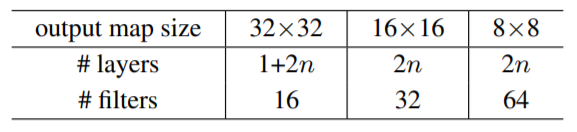

In [27]:
def _weights_init(m):
    classname = m.__class__.__name__
    #print(classname)
    if isinstance(m, nn.Linear) or isinstance(m, nn.Conv2d):
        init.kaiming_normal_(m.weight)

class BasicBlock(nn.Module):
    expansion = 1
    def __init__(self, in_channels, out_channels, stride=1):
        super(BasicBlock, self).__init__()

        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)

        if GN_LAYERS:
          self.gn1 = nn.GroupNorm(2, out_channels)
        else:
          self.bn1 = nn.BatchNorm2d(out_channels)

        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)

        if GN_LAYERS:
          self.gn2 = nn.GroupNorm(2, out_channels)
        else:
          self.bn2 = nn.BatchNorm2d(out_channels)

        self.shortcut = nn.Sequential()

        if stride != 1 or in_channels != out_channels:
          if GN_LAYERS:
              self.shortcut = nn.Sequential(
                  nn.Conv2d(in_channels, out_channels * self.expansion, kernel_size=1, stride=stride, bias=False),
                  nn.GroupNorm(2, out_channels * self.expansion)
              )
          else:
              self.shortcut = nn.Sequential(
                  nn.Conv2d(in_channels, out_channels * self.expansion, kernel_size=1, stride=stride, bias=False),
                  nn.BatchNorm2d(out_channels * self.expansion)
              )

        self.relu = nn.ReLU()
        self.stride = stride

    def forward(self, x):
        #identity = x

        out = self.conv1(x)

        if GN_LAYERS:
          out = self.gn1(out)
        else:
          out = self.bn1(out)

        out = self.relu(out)

        out = self.conv2(out)

        if GN_LAYERS:
          out = self.gn2(out)
        else:
          out = self.bn2(out)

        out += self.shortcut(x)

        """
        if self.identity_downsample is not None:
            identity = self.identity_downsample(identity)

        x += identity
        """
        out = self.relu(out)
        return out

"""ResNet"""
class ResNet(nn.Module):
    """
    - block = Basic Block / Bottleneck Block, in this case for a ResNet-20 we simply have a Basic Block
    - layers = a list which tells us how many times we want to use the Basic Block (look at Table 1 in the paper)
        f.e. in our case for ResNet-20 will be [3,2,2,2]
    - image channels = #channels of the input, for RGB it's 3
    - num_classes = 100 because we use CIFAR100
    """
    def __init__(self, block, layers, image_channels, num_classes=100):
        super(ResNet, self).__init__()
        # Here we're just defining the initial layers and the relu
        self.in_channels = 16
        self.conv1 = nn.Conv2d(image_channels, 16, kernel_size=3, stride=1, padding=1, bias=False)
        if GN_LAYERS:
          self.gn1 = nn.GroupNorm(2, 16)
        else:
          self.bn1 = nn.BatchNorm2d(16)
        self.relu = nn.ReLU()

        # Essentially the entire ResNet architecture are in these 4 lines below
        self.layer1 = self._make_layer(block, layers[0], out_channels=16, stride=1)
        self.layer2 = self._make_layer(block, layers[1], out_channels=32, stride=2)
        self.layer3 = self._make_layer(block, layers[2], out_channels=64, stride=2)
        self.linear = nn.Linear(64, num_classes)

        self.apply(_weights_init)

    def _make_layer(self, block, num_residual_blocks, out_channels, stride):
        """
        - block = same as before, either Basic Block or Bottleneck Block
        - num_residual_blocks = #times it's gonna use the block
        - out_channels = #channels it's gonna be when we're done with that layer
        - stride = the stride, because we halve by 2 every time we have a conv, except in conv2_x where we have stride = 1 
        """
        layers = []
        for i in range(num_residual_blocks):
            layers.append(BasicBlock(self.in_channels, out_channels))
            self.in_channels = out_channels * block.expansion

        return nn.Sequential(*layers)

    def forward(self, x):
        out = self.conv1(x)
        if GN_LAYERS:
          out = self.gn1(out)
        else:
          out = self.bn1(out)
        out = self.relu(out)

        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)

        out = torch.nn.functional.avg_pool2d(out, out.size()[3])
        #out = self.fc(x)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out

def resnet20(image_channels=3):
    return ResNet(BasicBlock, [3, 3, 3], image_channels)


def test():
    net = resnet20(image_channels=3)
    y = net(torch.randn(4, 3, 224, 224)).to("cuda")
    print(y.size())

test()
net = resnet20()
print(net)

torch.Size([4, 100])
ResNet(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (gn1): GroupNorm(2, 16, eps=1e-05, affine=True)
  (relu): ReLU()
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (gn1): GroupNorm(2, 16, eps=1e-05, affine=True)
      (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (gn2): GroupNorm(2, 16, eps=1e-05, affine=True)
      (shortcut): Sequential()
      (relu): ReLU()
    )
    (1): BasicBlock(
      (conv1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (gn1): GroupNorm(2, 16, eps=1e-05, affine=True)
      (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (gn2): GroupNorm(2, 16, eps=1e-05, affine=True)
      (shortcut): Sequential()
      (relu): ReLU()
    )
    (2): BasicBlock(
      (conv1): Conv2d(16,

**Prepare Training**

In [29]:
# Define loss function
criterion = nn.CrossEntropyLoss() # for classification, we use Cross Entropy



# Choose parameters to optimize and which one to freeze
if (FREEZE == 'no_freezing'):
  parameters_to_optimize = net.parameters() # In this case we optimize over all the parameters of AlexNet
elif (FREEZE == 'conv_layers'):
  parameters_to_optimize = net.classifier.parameters() # Updates only fully-connected layers (no conv)
elif (FREEZE == 'fc_layers'):
  parameters_to_optimize = net.features.parameters() # Updates only conv layers (no fc)
else :
  raise (ValueError(f"Error Freezing layers (FREEZE = {FREEZE}) \n Possible values are: 'no_freezing', 'conv_layers', 'fc_layers' "))


parameters_to_optimize = net.parameters()

# Define an optimizer. It updates the weights based on loss, we use SGD with momentum
optimizer = optim.SGD(parameters_to_optimize, lr=LR, momentum=MOMENTUM, weight_decay=WEIGHT_DECAY)

# Define scheduler. It dynamically changes the learning rate
#scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=STEP_SIZE, gamma=GAMMA)
if COSINE_ANNEALING:
  scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=NUM_EPOCHS, eta_min=0.00001)

**Train**

In [30]:
# (NEW) ------>
print("Current Hyperparameters: ")
print(f"N_EPOCHS: {NUM_EPOCHS}")
#print(f"STEP_SIZE: {scheduler.step_size}")
print(f"Optimizer: \n{optimizer}")

start = time.time()
# <------------


# By default, everything is loaded to cpu
net = net.to(DEVICE) # this will bring the network to GPU if DEVICE is cuda
cudnn.benchmark # calling this optimizes runtime



# save best config (NEW)
best_net = 0
best_epoch = 0
best_val_acc = 0.0

# save accuracy and loss (NEW)
train_accuracies = []
train_losses = []
val_accuracies = []
val_losses = []

current_step = 0
# Start iterating over the epochs
for epoch in range(NUM_EPOCHS):
  if COSINE_ANNEALING:
    print('Starting epoch {}/{}, LR = {}'.format(epoch+1, NUM_EPOCHS, scheduler.get_lr()))



  net.train() # Sets module in training mode: 
  #() => True => sto facendo il training del mio dataset
  #(False) => sto facendo la validation del mio dataset
  running_corrects_train = 0
  running_loss_train = 0.0

  lrs = []


  # Iterate over the dataset
  for images, labels in trainloader:
    images = images.to(DEVICE)
    labels = labels.to(DEVICE)

    """
    net.train() # Sets module in training mode
    """

    # PyTorch, by default, accumulates gradients after each backward pass
    # We need to manually set the gradients to zero before starting a new iteration
    optimizer.zero_grad()

    with torch.set_grad_enabled(True):
      # Forward pass to the network: for each image in the batch it produces 100 values that correspond
      # to the probability that the image belongs to one of the 100 classes
      outputs_train = net(images)

      # Prediction: for each image we assign the label with the highest probability
      _, preds = torch.max(outputs_train, 1)

      # Compute loss based on output and ground truth
      loss = criterion(outputs_train, labels)

      # Log loss
      if current_step % LOG_FREQUENCY == 0:
        print('Step {}, Loss {}'.format(current_step, loss.item()))

      # Compute gradients for each layer and update weights
      loss.backward()  # backward pass: computes gradients
      optimizer.step() # update weights based on accumulated gradients

    current_step += 1

  # Store loss and accuracy values
  running_corrects_train += torch.sum(preds == labels.data).data.item() 
  running_loss_train += loss.item() * images.size(0)
  
  train_acc = running_corrects_train / float(len(train_dataset))
  train_loss = running_loss_train / float(len(train_dataset))

  train_accuracies.append(train_acc)
  train_losses.append(train_loss) # loss computed as the average on mini-batches
  #train_loss.append(loss.item()) # loss computed only on the last batch

  ### END TRAINING PHASE OF AN EPOCH


  if (epoch+1) % 5 == 0: 

    # Evaluate accuracy on the validation set after each epoch
    net.train(False) # Set Network to evaluation mode

    running_corrects_val = 0
    running_loss_val = 0.0

      # Iterate over the dataset
    for images, labels in val_dataloader:
      images = images.to(DEVICE)
      labels = labels.to(DEVICE)

      # zero the parameter gradients
      optimizer.zero_grad()

      with torch.set_grad_enabled(False):

        # Forward Pass
        outputs = net(images) 

        # Get predictions
        _, preds = torch.max(outputs, 1)

        # Update Corrects
        running_corrects_val += torch.sum(preds == labels.data).data.item()

        # Calculate Loss
        loss = criterion(outputs.data, labels)

      # Update Corrects and Loss
      running_loss_val += loss.item() * images.size(0)
      running_corrects_val += torch.sum(preds == labels.data)

    # Compute epoch loss and accuracy
    val_loss = running_loss_val / float(len(val_dataset))
    val_acc = running_corrects_val / float(len(val_dataset))

    # memorize stats 
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)

    print(f"Validation Accuracy: {val_acc:.4f}")

    # Check if the current epoch val accuracy is better than the best found until now
    if (val_acc >= best_val_acc) : 
      best_val_acc = val_acc
      best_epoch = epoch
      best_net = copy.deepcopy(net) # deep copy the model

  # Step the scheduler
  if COSINE_ANNEALING:
    scheduler.step() 

print(f"\nBest epoch: {best_epoch+1}\n{best_val_acc:.4f} (Validation Accuracy)\n")
print(f"> In {(time.time()-start)/60:.2f} minutes")

Current Hyperparameters: 
N_EPOCHS: 160
Optimizer: 
SGD (
Parameter Group 0
    dampening: 0
    initial_lr: 0.1
    lr: 0.1
    momentum: 0.9
    nesterov: False
    weight_decay: 0.0001
)
Starting epoch 1/160, LR = [0.1]
Step 0, Loss 6.167237281799316
Step 25, Loss 4.6609907150268555
Step 50, Loss 4.632386207580566
Step 75, Loss 4.606993675231934
Step 100, Loss 4.592280387878418
Step 125, Loss 4.595300674438477
Step 150, Loss 4.604789733886719
Step 175, Loss 4.623774528503418
Step 200, Loss 4.629486083984375
Step 225, Loss 4.601849555969238
Step 250, Loss 4.624964714050293
Step 275, Loss 4.612184047698975
Step 300, Loss 4.610296249389648
Step 325, Loss 4.6101508140563965
Step 350, Loss 4.623154640197754
Starting epoch 2/160, LR = [0.09998072690461457]
Step 375, Loss 4.610291481018066
Step 400, Loss 4.6048736572265625
Step 425, Loss 4.598215579986572
Step 450, Loss 4.617631912231445
Step 475, Loss 4.6113600730896
Step 500, Loss 4.605740547180176
Step 525, Loss 4.611865997314453
Step 5

KeyboardInterrupt: ignored

Best accuracies on the validation set:  tensor(1.1560, device='cuda:0')


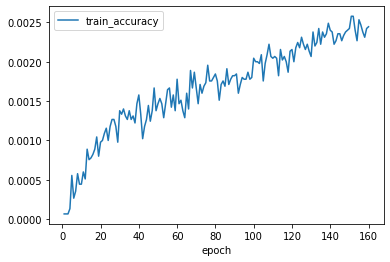

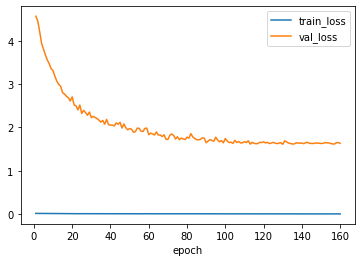

In [21]:
import pandas as pd
import matplotlib.pyplot as plt
print("Best accuracies on the validation set: ", val_acc)

results_df = pd.DataFrame(zip(range(1,NUM_EPOCHS+1), train_accuracies, val_accuracies, train_losses, val_losses), columns = ["epoch", "train_accuracy", "val_accuracy", "train_loss", "val_loss"])
results_df.set_index("epoch")
results_df.plot(x = "epoch", y = ["train_accuracy", "val_accuracy"])
results_df.plot(x = "epoch", y = ["train_loss", "val_loss"])

**Validation**

In [ ]:
net = net.to(DEVICE) # this will bring the network to GPU if DEVICE is cuda
net.train(False) # Set Network to evaluation mode

running_corrects = 0
for images, labels in tqdm(val_dataloader):
  images = images.to(DEVICE)
  labels = labels.to(DEVICE)

  # Forward Pass
  outputs = net(images)

  # Get predictions
  _, preds = torch.max(outputs.data, 1)

  # Update Corrects
  running_corrects += torch.sum(preds == labels.data).data.item()

# Calculate Accuracy
accuracy = running_corrects / float(len(val_dataset))

print('Validation Accuracy: {}'.format(accuracy))

  8%|▊         | 1/12 [00:04<00:44,  4.03s/it]

256


 17%|█▋        | 2/12 [00:04<00:18,  1.82s/it]

256


 25%|██▌       | 3/12 [00:04<00:10,  1.11s/it]

256


 33%|███▎      | 4/12 [00:04<00:06,  1.24it/s]

256


 42%|████▏     | 5/12 [00:07<00:09,  1.35s/it]

256


 50%|█████     | 6/12 [00:07<00:05,  1.03it/s]

256
256


 67%|██████▋   | 8/12 [00:07<00:02,  1.81it/s]

256


 83%|████████▎ | 10/12 [00:09<00:01,  1.42it/s]

256
256


 92%|█████████▏| 11/12 [00:09<00:00,  1.90it/s]

256
76


100%|██████████| 12/12 [00:10<00:00,  1.19it/s]

Validation Accuracy: 0.09232365145228216


**Test**

In [22]:
net = net.to(DEVICE) # this will bring the network to GPU if DEVICE is cuda
net.train(False) # Set Network to evaluation mode

running_corrects = 0
for images, labels in tqdm(testloader):
  images = images.to(DEVICE)
  labels = labels.to(DEVICE)

  # Forward Pass
  outputs = net(images)

  # Get predictions
  _, preds = torch.max(outputs.data, 1)

  # Update Corrects
  running_corrects += torch.sum(preds == labels.data).data.item()

# Calculate Accuracy
accuracy = running_corrects / float(len(test_dataset))

print('Test Accuracy: {}'.format(accuracy))

100%|██████████| 78/78 [00:03<00:00, 22.57it/s]

Test Accuracy: 0.5941
